<a href="https://colab.research.google.com/github/juanbeleno/meli-challenge-2020/blob/main/Meli_Challenge_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

[Mercado Libre Data Challenge 2020](https://ml-challenge.mercadolibre.com/) requires to build a ML model to predict the next item to be bought by a user based on his/her history of searches and views.

We start by installing the required libraries.



In [1]:
!pip install ujson==4.0.1
!pip install torch==1.7.0
!pip install sentence-transformers==0.3.8
!pip install fastprogress==1.0.0
!pip install scikit-learn==0.23.2
!nvidia-smi

     |████████████████████████████████| 184kB 9.8MB/s 
     |████████████████████████████████| 71kB 4.9MB/s 
     |████████████████████████████████| 1.1MB 10.1MB/s 
     |████████████████████████████████| 3.0MB 19.8MB/s 
     |████████████████████████████████| 890kB 29.9MB/s 
     |████████████████████████████████| 1.1MB 49.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.8-cp36-none-any.whl size=101996 sha256=e5239caff804b47c3eff79e77cd194750673ec1db6b347ac78e9f040d818b1fd
  Stored in directory: /root/.cache/pip/wheels/27/ec/b3/d12cc8e4daf77846db6543033d3a5642f204c0320b15945647
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=bb953249d03f8ad7959e160f9dc4cc5255a8766e7cdd77d04cfbd718bf9e5998
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses
     |████████████████████████████████| 6.8MB 7.4MB/s 
  F

Make sure you don't get disconected

In [19]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

## Setup

We setup Google Drive to access and write data.

In [2]:
# Setup Google drive
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/recursos_colab/meli_challenge_2020/'

RAW_TRAIN_DATASET_PATH = f'{root_path}train_dataset.jl.gz'
TRAIN_DATASET_PATH = f'{root_path}training_dataset.jl.gz'
OVERSAMPLED_TRAIN_DATASET_PATH = f'{root_path}oversampled_training_dataset.jl.gz'
VALIDATION_DATASET_PATH = f'{root_path}validation_dataset.jl.gz'
ITEM_DATA_PATH = f'{root_path}item_data.jl.gz'
TEST_DATASET_PATH = f'{root_path}test_dataset.jl.gz'
SAMPLE_SUBMISSION_PATH = f'{root_path}sample_submission.csv'

Mounted at /content/gdrive


Run the code below just once, there is no need to download the files on Google Drive more than once. The files are the item data, sample submission file, test and train dataset.

In [ ]:
# Download the files and store them in Google Drive
import requests
file_urls = {
    'test_dataset.jl.gz': 'https://meli-data-challenge.s3.amazonaws.com/2020/test_dataset.jl.gz',
    'train_dataset.jl.gz': 'https://meli-data-challenge.s3.amazonaws.com/2020/train_dataset.jl.gz',
    'item_data.jl.gz': 'https://meli-data-challenge.s3.amazonaws.com/2020/item_data.jl.gz',
    'sample_submission.csv': 'https://meli-data-challenge.s3.amazonaws.com/2020/sample_submission.csv'
}

# Source: https://stackoverflow.com/q/62285313
for file_name in file_urls:
  r = requests.get(file_urls[file_name], stream = True)
  with open(f'{root_path}{file_name}', "wb") as file:
      for block in r.iter_content(chunk_size = 1024):
          if block:
              file.write(block)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data exploration

The files have a Gzipped JSON Lines format and they use most of the RAM available on Google Colab (12GB), so I decided read the files line by line to save some RAM for model training usage. At this point, I'm only interested on two files: ```item_data.jl.gz``` and ```train_dataset.jl.gz```because they are used to train the model.

In [10]:
import gzip
import ujson

def print_first_lines(file_path, n=3):
    """Print the frist line of JSON Line file using identation of 4"""
    with gzip.open(file_path,'rt') as f:
        for index, line in enumerate(f):
            data = ujson.loads(line)
            print(ujson.dumps(data, indent=4))
            if index >= n-1:
              break

def blocks(files, size=65536):
    while True:
        b = files.read(size)
        if not b: break
        yield b

def print_num_lines(file_path):
    """Count the number of lines in a file"""
    with gzip.open(file_path,'rb') as f:
        print(sum(bl.decode().count("\n") for bl in blocks(f)))


As we can see below, the training data is structured as a dictionary of purchases, searches and views associated with a item bought. We cannot see searches or purchases on the example below, but we know they exist because is shown on the [documentation](https://ml-challenge.mercadolibre.com/downloads) of the challenge. Also, we want to know the number of lines in this file because it's important to create DataLoader that will help us loading batches of records on training instead of loading all the dataset at the same time. There are ```413163``` lines in this file.

In [13]:
print_first_lines(RAW_TRAIN_DATASET_PATH)
print_num_lines(RAW_TRAIN_DATASET_PATH)

{
    "user_history": [
        {
            "event_info": 1786148,
            "event_timestamp": "2019-10-19T11:25:42.444-0400",
            "event_type": "view"
        },
        {
            "event_info": 1786148,
            "event_timestamp": "2019-10-19T11:25:57.487-0400",
            "event_type": "view"
        },
        {
            "event_info": "RELOGIO SMARTWATCH",
            "event_timestamp": "2019-10-19T11:26:07.063-0400",
            "event_type": "search"
        },
        {
            "event_info": 1615991,
            "event_timestamp": "2019-10-19T11:27:26.879-0400",
            "event_type": "view"
        },
        {
            "event_info": 1615991,
            "event_timestamp": "2019-10-19T11:28:36.558-0400",
            "event_type": "view"
        },
        {
            "event_info": 1615991,
            "event_timestamp": "2019-10-19T11:28:40.827-0400",
            "event_type": "view"
        },
        {
            "event_info": 1615991,
    

When the event type on the user history is a view or a purchase, then we have an ```event_info``` associated with an ```item_id``` on the file ```item_data.jl.gz``` that has the following information:

In [14]:
print_first_lines(ITEM_DATA_PATH)

{
    "item_id": 111260,
    "title": "Casa Sola En Venta Con Gran Patio Solo Pago De Contado.",
    "domain_id": "MLM-INDIVIDUAL_HOUSES_FOR_SALE",
    "product_id": null,
    "price": "1150000.00",
    "category_id": "MLM170527",
    "condition": "new"
}
{
    "item_id": 871377,
    "title": "Resident Evil Origins Collection Nintendo Switch (en D3gamer",
    "domain_id": "MLM-VIDEO_GAMES",
    "product_id": "15270800",
    "price": "1392.83",
    "category_id": "MLM151595",
    "condition": "new"
}
{
    "item_id": 490232,
    "title": "Falda De Imitaci\u00f3n Piel Negra",
    "domain_id": "MLM-SKIRTS",
    "product_id": null,
    "price": "350.00",
    "category_id": "MLM7697",
    "condition": "new"
}


## Preparing the dataset

We structure the item data in a dictionary to access that info faster to augment the Dataset Loader.

In [3]:
import gzip
import ujson

item_details = {}
with gzip.open(ITEM_DATA_PATH,'rt') as f:
    for index, line in enumerate(f):
        data = ujson.loads(line)
        item_id = data['item_id']
        item_details[item_id] = data

The first thing I need to do is to split the train dataset between validation and training set. This allows me to fine tune the model without submitting it to the platform each time. The submissions per day are limited to 3 so I prefer to validate my model before submission. In this process, I'm going to delete the item of categories that only have one sample to reduce the complexity of the problem.

In [4]:
from collections import Counter
from sklearn.model_selection import train_test_split
import gzip
import ujson
import random
import math


def write_dataset(lines, file_path):
  with gzip.open(file_path, 'wt') as f:
      for index, line in enumerate(lines):
          new_line = line.strip(' \n\r\t')
          if index == 0:
              f.write(new_line)
          else:
              f.write(f'\n{new_line}')

# We create a dictionary associating domains with their frequency on the
# training set
classes = []
with gzip.open(RAW_TRAIN_DATASET_PATH,'rt') as f:
    classes = [item_details[ujson.loads(x)['item_bought']]['domain_id'] for x in f.readlines()]
domain_counter = Counter(classes)

lines = []
classes = []
with gzip.open(RAW_TRAIN_DATASET_PATH,'rt') as f:
    for line in f:
        data = ujson.loads(line)
        item_bought = data['item_bought']
        domain_id = item_details[item_bought]['domain_id']
        if domain_counter[domain_id] > 1:
            lines.append(line)
            classes.append(domain_id)

# Order randomlly the data to improve the SGD on the model
train_lines, val_lines = train_test_split(
    lines, test_size=0.2, stratify=classes, shuffle=True, random_state=42)

write_dataset(train_lines, TRAIN_DATASET_PATH)
write_dataset(val_lines, VALIDATION_DATASET_PATH)

NUM_TRAINING_SAMPLES = len(train_lines)
NUM_VALIDATION_SAMPLES = len(val_lines)
print(f'Number of lines for training: {NUM_TRAINING_SAMPLES}')
print(f'Number of lines for validation: {NUM_VALIDATION_SAMPLES}')

train_lines = None
val_lines = None

Number of lines for training: 371507
Number of lines for validation: 41279


### Oversampling

I'm going to increase the number of samples per domain for underrepresented domains. The threshold I'll use is **55** samples because it is the median of the samples per domain.

In [4]:
from collections import Counter
import gzip
import ujson
import math
import random

# We create a dictionary associating domains with their frequency on the
# training set
classes = []
with gzip.open(TRAIN_DATASET_PATH,'rt') as f:
    classes = [item_details[ujson.loads(x)['item_bought']]['domain_id'] for x in f.readlines()]
domain_counter = Counter(classes)
classes = []

# Oversampling
threshold = 235
lines = []
with gzip.open(TRAIN_DATASET_PATH,'rt') as f:
    for line in f:
        record = ujson.loads(line)
        item_id = record['item_bought']
        item = item_details[item_id]
        domain_id = item['domain_id']

        if domain_counter[domain_id] < threshold:
            # Oversampling
            num_samples = math.floor(threshold * 1.0 / domain_counter[domain_id])
            sample_probability = (threshold * 1.0 / domain_counter[domain_id]) - num_samples
            random_seed = random.uniform(0, 1)

            if num_samples > 0:
                for index in range(num_samples):
                    lines.append(line)

            if random_seed <= sample_probability:
                lines.append(line)
        else:
            lines.append(line)

# Shuffle the dataset to avoid having duplicated data on continuous lines
random.shuffle(lines)

with gzip.open(OVERSAMPLED_TRAIN_DATASET_PATH, 'wt') as f:
    for index, line in enumerate(lines):
        new_line = line.strip(' \n\r\t')
        if index == 0:
            f.write(new_line)
        else:
            f.write(f'\n{new_line}')

NUM_OVERSAMPLED_TRAINING_SAMPLES = len(lines)
print(f'Number of lines for training: {NUM_OVERSAMPLED_TRAINING_SAMPLES}')
lines = None


Number of lines for training: 879286


In [5]:
NUM_TRAINING_SAMPLES = 371507
NUM_VALIDATION_SAMPLES = 41279
NUM_OVERSAMPLED_TRAINING_SAMPLES = 879286

TRAIN_DATASET_PATH = OVERSAMPLED_TRAIN_DATASET_PATH
NUM_TRAINING_SAMPLES = NUM_OVERSAMPLED_TRAINING_SAMPLES

Based on the idea that possibly not all the items in the set of item_details were bought in the training dataset. I will predict only the items and domains that appear in the training dataset. At the same time, I'm going to get some stats about the distribution of domains in the training set to know how oversample the minority of domains.



In [6]:
import gzip
import ujson

domain_map = {}
categories_map = {}
reduced_feature_map = {}
domain_freq = {}
top_items_per_domain = {}
with gzip.open(TRAIN_DATASET_PATH,'rt') as f:
  for line in f:
    record = ujson.loads(line)
    item_id = record['item_bought']
    item = item_details[item_id]
    domain_id = item['domain_id']
    category_id = item['category_id']

    # Find the number of times a domain appears on the training set
    domain_freq[domain_id] = domain_freq.get(domain_id, 0) + 1

    # Map domains to integers
    if domain_id not in domain_map:
      domain_map[domain_id] = len(domain_map)

    # Map categories to integers
    if category_id not in categories_map:
      categories_map[category_id] = len(categories_map)

    # Creating the dependencies in the prediction
    if domain_id not in reduced_feature_map:
      reduced_feature_map[domain_id] = {}
    if item_id not in reduced_feature_map[domain_id]:
      reduced_feature_map[domain_id][item_id] = len(reduced_feature_map[domain_id])
    
    # Finding the most bought items per domain
    if domain_map[domain_id] not in top_items_per_domain:
      top_items_per_domain[domain_map[domain_id]] = {}
    top_items_per_domain[domain_map[domain_id]][item_id] = top_items_per_domain[domain_map[domain_id]].get(item_id, 0) + 1



In [7]:
print(f'Items size: {len(item_details)}')
print(f'Domains size: {len(domain_map)}')
print(f'Categories size: {len(categories_map)}')
features_sizes = [len(reduced_feature_map[domain]) for domain in reduced_feature_map]
print(f'Min Features: {min(features_sizes)}')
print(f'Max Features: {max(features_sizes)}')
print(f'Average Features: {sum(features_sizes)/len(features_sizes)}')
sorted_freqs = {k: v for k, v in sorted(domain_freq.items(), key=lambda item: item[1], reverse=False)}
print(list(sorted_freqs.keys())[:5])
print(list(sorted_freqs.values())[:25])

NUM_ITEMS_PER_DOMAIN = max(features_sizes)
NUM_DOMAINS = len(domain_map)
NUM_CATEGORIES = len(categories_map)

Items size: 2102277
Domains size: 2837
Categories size: 3615
Min Features: 1
Max Features: 2513
Average Features: 22.058160028198802
['MLB-BEER_DISPENSERS', 'MLM-AEROBICS_AND_FITNESS_EQUIPMENT', 'MLM-FACIAL_SKIN_CARE_PRODUCTS', 'MLB-UNDERWEAR_ORGANIZERS', 'MLM-WATER_DISPENSERS']
[222, 222, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 226, 226, 226, 226, 226, 226, 227, 227, 227, 227]


Find the percentile 75% for domains to know how many samples need to be oversampled for domains with less than that threshold.

P_75: 55


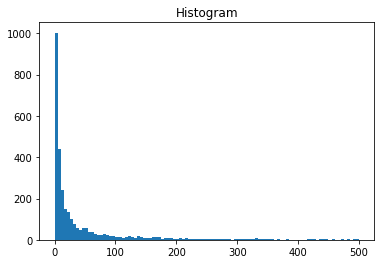

In [20]:
import matplotlib.pyplot as plt
import math

freq_values = list(domain_freq.values())
freq_values.sort()
percentile = freq_values[math.ceil(len(freq_values)*75/100)]
print(f'P_75: {percentile}')

plt.hist(freq_values, bins=100, range=(0, 500))
plt.title("Histogram")
plt.show()

**Dataset Loader:** The dataset loader provides the following features:
* The average of the sentence embeddings for item titles for views
* The average of the sentence embeddings for searches
* A sparse matrix showing the count of domains that appears on views

The possible targets for the models are item identifiers, domain numerical identifiers, and categories numerical identifiers

In [8]:
# Ideas:
# Use the dataset without oversampling
# Use the items on views and purchases as possible outcomes
# Transform the domain sparse embeddings to a dense one using sentence embeddings
#   over the domain_id (it has legible text, so we can use it). Remove the first
#   3 letters and the dash, remove the underscores.
# Find if we can use the 3 first letters before the dash on domain_id as a separated feature
from torch.utils.data import Dataset
from sentence_transformers import SentenceTransformer
import gzip
import math
import numpy as np
import pandas as pd
import torch
import ujson
torch.multiprocessing.set_start_method('spawn')# good solution !!!!

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

class MultiTaskDataset(Dataset):
    def __init__(self, file_path, config):
        self.file_path = file_path
        self.config = config
        self.sentence_model = SentenceTransformer('average_word_embeddings_glove.6B.300d')
        self.sentence_model = self.sentence_model.to(device)
        self.f = gzip.open(self.file_path, 'r')

    def __len__(self):
        return self.config['data_size']

    def __getitem__(self, idx):
        """Getting and preprocessing the inputs"""
        if idx == 0:
            # Each time a epoch starts, we close the file, open it again, and
            # seek the first line just to be sure it starts at the beginning of
            # the file
            self.f.close()
            self.f = gzip.open(self.file_path, 'r')
            self.f.seek(0)
        response = {}

        # Read the line in the file and transform it in JSON
        line = self.f.readline()
        try:
            raw_data = ujson.loads(line)
        except:
            # Sometimes the connection to the file closes unexpectedly, so we
            # handle that problem here
            self.f.close()
            self.f = gzip.open(self.file_path, 'r')
            self.f.seek(0)
            for i in range(idx + 1):
                line = self.f.readline()
            raw_data = ujson.loads(line)

        # Identify the historic of a user and the item bought if exist
        # We are going to use the same Data Loader for the test dataset, which
        # does not have 'item_bought'
        user_history = self.normalize_user_history(raw_data['user_history'])
        item_bought = None
        if 'item_bought' in raw_data:
            item_bought = raw_data['item_bought']

        views = []
        searches = []
        # The embedding size produced by DISTILLBERT is 768. GloVe embeddings
        # have 300 dimensions. DISTILLBERT embeddings are more useful than the
        # ones produced by GloVe, but they take like 6 times more of computing
        # time.
        #embedding_size = 768
        embedding_size = 300

        # By default, we fill the embeddings with zeros
        avg_view_embeddings = np.zeros(embedding_size)
        avg_search_embeddings = np.zeros(embedding_size)
        category_embeddings = np.zeros(NUM_CATEGORIES)
        domain_embeddings = np.zeros(NUM_DOMAINS)
        price_embedding = np.zeros(5)
        condition_embedding = np.zeros(2)
        candidates = []

        if len(user_history) > 0:

            # Assumption #1: The item_bought probably is on the views or at
            # least the items are in the same domain or a similar one.

            for item in reversed(user_history):
                if item['event_type'] != 'search':
                    candidates.append(int(item['event_info']))

            prices = []
            # First position are the new items and the second position is for
            # second had items
            conditions = [0,0]
            for item in user_history:
                # Iterate over the items in the user_history and find the text
                # in searches or extract the item titles for views.
                if item['event_type'] == 'search':
                    text = item['event_info']
                    searches.append(text)
                else:
                    # Find the domains that appear on the views
                    domain_id = item_details[item['event_info']]['domain_id']
                    if domain_id in domain_map:
                        domain_embeddings[domain_map[domain_id]] = domain_embeddings[domain_map[domain_id]] + 1
                    
                    # Find the categories that appear on the views
                    category_id = item_details[item['event_info']]['category_id']
                    if category_id in categories_map:
                        category_embeddings[categories_map[category_id]] = category_embeddings[categories_map[category_id]] + 1

                    # Include all the prices of items of views
                    price = item_details[item['event_info']]['price']
                    if price:
                        price = float(price)
                        prices.append(price)

                    # Include the item condition
                    condition = item_details[item['event_info']]['condition']
                    if condition == 'new':
                        conditions[0] = conditions[0] + 1
                    else:
                        conditions[1] = conditions[1] + 1

                    text = item_details[item['event_info']]['title']
                    views.append(text)

            # If there are prices, then calculate a simple embedding using
            # cumulative metrics like min, max, mean, median, standard deviation
            if len(prices) > 0:
                prices = np.array(prices)
                price_embedding[0] = np.min(prices)
                price_embedding[1] = np.max(prices)
                price_embedding[2] = np.nanmedian(prices)
                price_embedding[3] = np.nanmean(prices)
                price_embedding[4] = np.nanstd(prices)
            
            # If there are conditions for items, then normalize the list
            if sum(conditions) > 0:
                conditions = np.array(conditions)
                condition_embedding[0] = conditions[0] / np.sum(conditions)
                condition_embedding[1] = conditions[1] / np.sum(conditions)

            # If there are views, then calculate the view embeddings from the
            # item title on the views
            if len(views) > 0:
                view_embeddings = self.sentence_model.encode(views)
                avg_view_embeddings = self.embeddings_weighted_average(view_embeddings)

            # If there are searches, the calculate the search embeddings from them
            if len(searches) > 0:
                search_embeddings = self.sentence_model.encode(searches)
                avg_search_embeddings = self.embeddings_weighted_average(search_embeddings)

        # Assign the values to the features
        response['view_embeddings'] = avg_view_embeddings
        response['search_embeddings'] = avg_search_embeddings
        response['domain_embeddings'] = domain_embeddings
        response['category_embeddings'] = category_embeddings
        response['price_embedding'] = price_embedding
        response['condition_embedding'] = condition_embedding
        response['candidates'] = candidates[:10]

        # If we are handling the training or validation set, then we also get
        # the domain, category and item identifiers
        if item_bought:
            item_data = item_details[item_bought]
            domain_id = item_data['domain_id']
            category_id = item_data['category_id']

            # We need to verify the values for targets because some items,
            # domains, and categories can appear on the trainig set but not
            # on the validation set
            domain_map_id = NUM_DOMAINS
            category_map_id = NUM_CATEGORIES
            item_map_id = NUM_ITEMS_PER_DOMAIN
            if domain_id in domain_map:
                domain_map_id = domain_map[domain_id]
                if item_bought in reduced_feature_map.get(domain_id, {}):
                    item_map_id = reduced_feature_map[domain_id][item_bought]
            if category_id in categories_map:
                category_map_id = categories_map[category_id]

            # Set the value for the targets
            response['item'] = torch.tensor(
                item_map_id, dtype=torch.long)
            response['domain'] = torch.tensor(
                domain_map_id, dtype=torch.long)
            response['category'] = torch.tensor(
                category_map_id, dtype=torch.long)
        return response

    def normalize_user_history(sefl, user_history):
      # Remove duplicated views and searches that appear almost at the same time
      new_user_history = []
      last_item_id = ''
      for item in user_history:
        current_item_id = item['event_info']
        if current_item_id != last_item_id:
          new_user_history.append(item)
        last_item_id = current_item_id
      # We are only going to consider the last 15 events
      return new_user_history[-20:]

    def embeddings_weighted_average(self, embeddings):
      # I'm going to use a logarithmic decrease in the importance of each
      # view or search according to its recency
      embeddings_size = embeddings.shape[0]
      avg_embeddings = embeddings
      if embeddings_size >= 1:
        weights = [1.0 / math.log2(2 + index) for index in range(embeddings_size)]
        normal_weigths = [float(w)/sum(weights) for w in weights]
        # The last item in the embeddings is the most recent
        normal_weigths = np.array(list(reversed(normal_weigths)))
        avg_embeddings = embeddings * normal_weigths.reshape((normal_weigths.size, 1))
        avg_embeddings = np.sum(avg_embeddings, axis=0)
      return avg_embeddings
        


Device: cuda:0


Get the data loader for training and validation.

In [9]:
from torch.utils.data import DataLoader
import numpy as np

BATCH_SIZE = 128

def my_train_collate(batch):
    '''Get features and targets'''
    # Features
    searches = torch.from_numpy(np.array([item['search_embeddings'] for item in batch]))
    views = torch.from_numpy(np.array([item['view_embeddings'] for item in batch]))
    domain_views = torch.from_numpy(np.array([item['domain_embeddings'] for item in batch]))
    categories = torch.from_numpy(np.array([item['category_embeddings'] for item in batch]))
    prices = torch.from_numpy(np.array([item['price_embedding'] for item in batch]))
    conditions = torch.from_numpy(np.array([item['condition_embedding'] for item in batch]))
    candidates = torch.from_numpy(np.array([item['candidates'] for item in batch]))

    # Targets
    items = [item['item'] for item in batch]
    items = torch.LongTensor(items)
    domains = [item['domain'] for item in batch]
    domains = torch.LongTensor(domains)
    return {
        'searches': searches,
        'views': views,
        'domain_views': domain_views,
        'categories': categories,
        'prices': prices,
        'conditions': conditions,
        'candidates': candidates,
        'items': items,
        'domains': domains
    }

# Get the Dataset Loader for training
training_config = {
    'data_size': NUM_TRAINING_SAMPLES,
    'batch_size': BATCH_SIZE
}
ds_train = MultiTaskDataset(TRAIN_DATASET_PATH, training_config)
training_loader = DataLoader(
    ds_train, batch_size=BATCH_SIZE, num_workers=0, collate_fn=my_train_collate,
    pin_memory=True, shuffle=True)

# Get the Dataset Loader for validation
validation_config = {
    'data_size': NUM_VALIDATION_SAMPLES,
    'batch_size': BATCH_SIZE
}
ds_val = MultiTaskDataset(VALIDATION_DATASET_PATH, validation_config)
validation_loader = DataLoader(
    ds_val, batch_size=BATCH_SIZE, num_workers=0, collate_fn=my_train_collate,
    pin_memory=True, shuffle=True)

# Notes:
# * I found a buggy behavior when num_workers != 0, then I set it that way.
# * pin_memory is True to save some memory and speed up the training process.
# * shuffle is True to give a little bit of randomness each epoch

100%|██████████| 441M/441M [00:25<00:00, 17.2MB/s]


## Creating the model

The model is the ```bert-case-uncased``` version of BERT provided by HugginFaces.

In [10]:
import torch.nn as nn
import torch


class MultiTaskModel(nn.Module):
    """
    Creates a MultiTask model for classifications of domains and items based on
    the same text
    """
    def __init__(self):
        super().__init__()
        #num_items = 2102277
        num_items_per_domain = NUM_ITEMS_PER_DOMAIN
        num_domains = NUM_DOMAINS
        num_categories = NUM_CATEGORIES

        # The embedding size produced by DISTILLBERT is 768. GloVe embeddings
        # have 300 dimensions. DISTILLBERT embeddings are more useful than the
        # ones produced by GloVe, but they take like 6 times more of computing
        # time.
        #embedding_size = 768
        embedding_size = 300

        # Inputs to hidden layer linear transformation
        self.dropout = nn.Dropout(0.1)
        self.hidden_1 = nn.Linear(embedding_size * 2 + num_domains + 5 + 2, 1024)
        self.hidden_1_relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=0.1)
        self.hidden_2 = nn.Linear(1024, 512)
        self.hidden_2_relu = nn.ReLU()
        self.dropout_2 = nn.Dropout(p=0.1)
        self.hidden_3 = nn.Linear(512, 256)
        self.hidden_3_relu = nn.ReLU()
        self.dropout_3 = nn.Dropout(p=0.1)

        # Output layers
        self.output_domains = nn.Linear(256, num_domains)
        self.domain_relu = nn.ReLU()
        self.domain_dropout = nn.Dropout(p=0.1)
        #self.output_items = nn.Linear(256, num_items_per_domain)
        #self.items_relu = nn.ReLU()
        #self.items_dropout = nn.Dropout(p=0.1)

        # Define the softmax output
        self.log_softmax_domains = nn.LogSoftmax(dim=1)
        #self.log_softmax_items = nn.LogSoftmax(dim=1)

    def forward(self, views, searches, domain_views, prices, conditions):
        # Pass the input tensor through each of our operations
        inputs = torch.cat(
            (views, searches, domain_views, prices, conditions), dim=1)
        x = self.dropout(inputs)
        x = self.hidden_1(inputs)
        x = self.hidden_1_relu(x)
        x = self.dropout_1(x)
        x = self.hidden_2(x)
        x = self.hidden_2_relu(x)
        x = self.dropout_2(x)
        x = self.hidden_3(x)
        x = self.hidden_3_relu(x)

        x_domains = self.output_domains(x)
        x_domains = self.domain_relu(x_domains)
        x_domains = self.domain_dropout(x_domains)
        y_domains = self.log_softmax_domains(x_domains)

        #_items = self.output_items(x)
        #x_items = self.items_relu(x_items)
        #x_items = self.items_dropout(x_items)
        #y_items = self.log_softmax_items(x_items)

        return y_domains#, y_items

## Training


In [11]:
import math
from collections import Counter

def get_items_for_domain(domain_id, n=10):
    candidates = dict(Counter(top_items_per_domain[domain_id]).most_common(n))
    candidates = list(candidates.keys())
    while len(candidates) < n:
        candidates.append(candidates[0])
    return candidates

def get_feature_map(reduced_feature_map, domain_map):
    features_map = {}
    for domain in reduced_feature_map:
        for item in reduced_feature_map[domain]:
            domain_id = domain_map[domain]
            item_id = reduced_feature_map[domain][item]

            if domain_id not in features_map:
                features_map[domain_id] = {}
            if item_id not in features_map[domain_id]:
                features_map[domain_id][item_id] = item
    return features_map

features_map = get_feature_map(reduced_feature_map, domain_map)

def get_metric(d_predictions, i_predictions, items, domains):
    num_correct = 0
    for index, domain in enumerate(d_predictions.tolist()):
        candidates = []
        true_item = None
        true_domain = int(domains[index].data)
        if true_domain == domain:
            true_item_id = int(items[index].data)
            if true_item_id in features_map[domain]:
                true_item = features_map[domain][true_item_id]
            default_item = list(features_map[domain].values())[0]
            for item_candidate in i_predictions[index]:
                item_id = features_map[domain].get(item_candidate, None)
                if item_id and len(candidates) < 10:
                    candidates.append(item_id)
            candidates.extend([default_item] * (10 - len(candidates)))

        if (len(candidates) > 0) and (true_item in candidates):
            index_find = candidates.index(true_item)
            numerator = sum([12 / math.log(2 + x) if x == index_find else 1 / math.log(2 + x) for x in range(10)])
            denominator = sum([12 / math.log(2 + x) if x == 0 else 1 / math.log(2 + x) for x in range(10)])
            num_correct += numerator * 1.0 / denominator
        elif len(candidates) > 0:
            numerator = sum([1 / math.log(2 + x) for x in range(10)])
            denominator = sum([12 / math.log(2 + x) if x == 0 else 1 / math.log(2 + x) for x in range(10)])
            num_correct += numerator * 1.0 / denominator
        else:
            num_correct += 0
    return num_correct

def get_metric_from_domain(predictions, domains, items):
    num_correct = 0
    for index, domain in enumerate(predictions.tolist()):
        candidates = []
        true_item = None
        domain_candidates = domain
        num_domains = len(domain_candidates)

        item_dist = {
            1: [10],
            2: [5, 5],
            3: [4, 3, 3],
            4: [3, 3, 2, 2],
            5: [2, 2, 2, 2, 2],
            6: [2, 2, 2, 2, 1, 1],
            7: [2, 2, 2, 1, 1, 1, 1],
            8: [2, 2, 1, 1, 1, 1, 1, 1],
            9: [2, 1, 1, 1, 1, 1, 1, 1, 1],
            10: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
        }
        true_domain = int(domains[index].data)
        domain_pos = None
        if true_domain in domain_candidates:
            domain_pos = domain_candidates.index(true_domain)
            true_item_id = int(items[index].data)
            if true_item_id in features_map[true_domain]:
                true_item = features_map[true_domain][true_item_id]
            num_items = item_dist[num_domains][domain_pos]
            candidates = get_items_for_domain(domain_candidates[domain_pos], num_items)

        if domain_pos is not None:
            start_value = sum(item_dist[num_domains][:domain_pos])
            end_value = start_value + item_dist[num_domains][domain_pos]
            range_values = range(start_value, end_value)
        if (len(candidates) > 0) and (true_item in candidates):
            index_find = candidates.index(true_item)
            numerator = sum([12 / math.log(2 + x) if x == index_find else 1 / math.log(2 + x) for x in range_values])
            denominator = sum([12 / math.log(2 + x) if x == 0 else 1 / math.log(2 + x) for x in range_values])
            num_correct += numerator * 1.0 / denominator
        elif len(candidates) > 0:
            numerator = sum([1 / math.log(2 + x) for x in range_values])
            denominator = sum([12 / math.log(2 + x) if x == 0 else 1 / math.log(2 + x) for x in range_values])
            num_correct += numerator * 1.0 / denominator
        else:
            num_correct += 0
    return num_correct


In [12]:
from fastprogress import master_bar, progress_bar
import torch.nn as nn
import torch.optim as optim
import torch


# Define model and let it use the GPU
#MODEL_PATH = f'{root_path}model-11.pth'
model = MultiTaskModel()
#model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(device)

# Define the loss for multi-task classification and let it use the GPU
criterion = [nn.NLLLoss(), nn.NLLLoss()]
criterion[0] = criterion[0].to(device)
criterion[1] = criterion[1].to(device)

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# After the second epoch, the loss does not vary much and I just need to know
# what combination of features + model is the best, so I prefer to user the
# minimum resources available
epochs = 4
mb = master_bar(range(epochs))

for epoch in mb:
    print(f'Epoch: {epoch}')
    print('-' * 10)
    running_loss = 0.0

    # Training phase
    # ----------------
    #model.train()
    for record in progress_bar(training_loader, parent=mb):
        # Transform features and target to use the GPU
        views = record['views'].to(device)
        searches = record['searches'].to(device)
        domain_views = record['domain_views'].to(device)
        #categories = record['categories'].to(device)
        prices = record['prices'].to(device)
        conditions = record['conditions'].to(device)

        items = record['items'].to(device)
        domains = record['domains'].to(device)

        # Reset the optimizer: Don't reuse info about the last batches
        optimizer.zero_grad()

        output_domains = model(
            views.float(), searches.float(), domain_views.float(),
            prices.float(), conditions.float())
        #loss_items = criterion[0](output_items, items)
        loss_domains = criterion[0](output_domains, domains)
        #loss = loss_items + loss_domains
        loss = loss_domains

        # backward + optimize only if the model is in training phase
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(training_loader)}")

Epoch: 0
----------
Training loss: 13.660987447061219
Epoch: 1
----------
Training loss: 7.789095156335067
Epoch: 2
----------
Training loss: 7.718504567680748
Epoch: 3
----------
Training loss: 7.968944300453042


In [13]:
# Validation phase
# ----------------
model.eval()
num_correct_domains = 0
num_samples = 0
num_correct_items = 0
correct_domains = {
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 0,
    10: 0
}
with torch.no_grad():
    for record in progress_bar(validation_loader):
        # Prepare features to use the GPU
        views = record['views'].to(device)
        searches = record['searches'].to(device)
        domain_views = record['domain_views'].to(device)
        #categories = record['categories'].to(device)
        prices = record['prices'].to(device)
        conditions = record['conditions'].to(device)

        domains = record['domains'].to(device)
        items = record['items'].to(device)

        # Get the predictions
        p_domains = model(
            views.float(), searches.float(), domain_views.float(),
            prices.float(), conditions.float())
        _, d_predictions = p_domains.max(1)
        _, d_predictions1 = torch.topk(p_domains, 1)
        _, d_predictions2 = torch.topk(p_domains, 2)
        _, d_predictions3 = torch.topk(p_domains, 3)
        _, d_predictions4 = torch.topk(p_domains, 4)
        _, d_predictions5 = torch.topk(p_domains, 5)
        _, d_predictions6 = torch.topk(p_domains, 6)
        _, d_predictions7 = torch.topk(p_domains, 7)
        _, d_predictions8 = torch.topk(p_domains, 8)
        _, d_predictions9 = torch.topk(p_domains, 9)
        _, d_predictions10 = torch.topk(p_domains, 10)
        #_, i_predictions = torch.topk(p_items, 50)

        correct_domains[1] += get_metric_from_domain(d_predictions1, domains, items)
        correct_domains[2] += get_metric_from_domain(d_predictions2, domains, items)
        correct_domains[3] += get_metric_from_domain(d_predictions3, domains, items)
        correct_domains[4] += get_metric_from_domain(d_predictions4, domains, items)
        correct_domains[5] += get_metric_from_domain(d_predictions5, domains, items)
        correct_domains[6] += get_metric_from_domain(d_predictions6, domains, items)
        correct_domains[7] += get_metric_from_domain(d_predictions7, domains, items)
        correct_domains[8] += get_metric_from_domain(d_predictions8, domains, items)
        correct_domains[9] += get_metric_from_domain(d_predictions9, domains, items)
        correct_domains[10] += get_metric_from_domain(d_predictions10, domains, items)
        # Get metrics
        #num_correct_items += get_metric(d_predictions, i_predictions, items, domains)

        num_correct_domains += (d_predictions == domains).sum()
        num_samples += d_predictions.size(0)
    print(f'Got {num_correct_domains} / {num_samples} with accuracy {float(num_correct_domains)/float(num_samples)*100:.2f}')
    #print(f'Got {num_correct_items} / {num_samples} with DCG {float(num_correct_items)/float(num_samples):.2f}')
    for num_domains in correct_domains:
        print(f'# Domains {num_domains} Got {correct_domains[num_domains]} / {num_samples} with DCG {float(correct_domains[num_domains])/float(num_samples):.2f}')

Got 4061 / 41279 with accuracy 9.84
# Domains 1 Got 1489.3099804823757 / 41279 with DCG 0.04
# Domains 2 Got 1748.937197962486 / 41279 with DCG 0.04
# Domains 3 Got 1998.0266370786287 / 41279 with DCG 0.05
# Domains 4 Got 2124.0158107681423 / 41279 with DCG 0.05
# Domains 5 Got 2212.4148437592858 / 41279 with DCG 0.05
# Domains 6 Got 2533.4148437592858 / 41279 with DCG 0.06
# Domains 7 Got 2791.414843759286 / 41279 with DCG 0.07
# Domains 8 Got 2940.31869711749 / 41279 with DCG 0.07
# Domains 9 Got 3061.318697117491 / 41279 with DCG 0.07
# Domains 10 Got 2962.1666666666665 / 41279 with DCG 0.07


Let's define where to store the model..



In [14]:
import torch

MODEL_PATH = f'{root_path}model-11.pth'

Let's store the model.

In [15]:
torch.save(model.state_dict(), MODEL_PATH)

## Prediction

Before sending the answer to this challenge, we need to see the format for the output.

In [ ]:
with open(SAMPLE_SUBMISSION_PATH,'rt') as f:
    for index, line in enumerate(f):
        if index < 4:
            print(line)
print(f'Number of lines: {index + 1}')

654238,781750,558980,663439,1397720,1095079,798751,1141944,411021,138117

462167,1511283,928291,1907892,66135,54134,1090655,700291,63494,613724

2092880,1974491,1687910,371918,1659351,156119,578171,1407298,1378300,500637

614011,509284,181629,1544217,267392,409673,755307,1621679,767644,617841

Number of lines: 177070


If Google Colab closed the connection before testing, we can get the model from Google Drive.

In [ ]:
# Optional
model = MultiTaskModel()
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(device)

We define the Data Loader for the testing set

In [63]:
from torch.utils.data import DataLoader
import numpy as np

BATCH_SIZE = 64
NUM_TESTING_SAMPLES = 177070

def my_test_collate(batch):
    """Get only the features because for testing we have to produce the targets"""
    searches = torch.from_numpy(np.array([item['search_embeddings'] for item in batch]))
    views = torch.from_numpy(np.array([item['view_embeddings'] for item in batch]))
    domain_views = torch.from_numpy(np.array([item['domain_embeddings'] for item in batch]))
    categories = torch.from_numpy(np.array([item['category_embeddings'] for item in batch]))
    prices = torch.from_numpy(np.array([item['price_embedding'] for item in batch]))
    conditions = torch.from_numpy(np.array([item['condition_embedding'] for item in batch]))
    return {
        'searches': searches,
        'views': views,
        'domain_views': domain_views,
        'categories': categories,
        'prices': prices,
        'conditions': conditions
    }

test_config = {
    'data_size': NUM_TESTING_SAMPLES,
    'batch_size': BATCH_SIZE
}
ds_test = MultiTaskDataset(TEST_DATASET_PATH, test_config)
test_loader = DataLoader(
    ds_test, batch_size=BATCH_SIZE, num_workers=0, collate_fn=my_test_collate,
    pin_memory=True)

Get the predictions for domains and fill the item identifiers with the most popular items per domain. If there is only one item in a domain repeat it until get the necessary 10 items per record.

In [59]:
def get_predictions_for_domains(predictions):
    candidates = []
    for index, domains in enumerate(predictions.tolist()):
        subset = []
        for domain in domains:
            subset.extend(get_items_for_domain(domain, 1))
        candidates.append(subset)
    return candidates

In [64]:
from collections import Counter


def get_predictions(model, data_loader):
    """Get item identifiers that the user will probably buy"""
    model = model.eval()
    predictions = []

    with torch.no_grad():
        for record in test_loader:
            # Prepare features to use the GPU
            views = record['views'].to(device)
            searches = record['searches'].to(device)
            domain_views = record['domain_views'].to(device)
            #categories = record['categories'].to(device)
            prices = record['prices'].to(device)
            conditions = record['conditions'].to(device)

            # Get the predictions
            domains = model(
                views.float(), searches.float(), domain_views.float(),
                prices.float(), conditions.float())
            _, preds_domains = torch.topk(domains, 10)
            preds = get_predictions_for_domains(preds_domains)
            #print(preds)
            predictions.extend(preds)
    return predictions


predictions = get_predictions(model, test_loader)

KeyboardInterrupt: ignored

Store our submission file with the predictions generated above

In [ ]:
SUBMISSION_PATH = f'{root_path}real_submission_11.csv'
with open(SUBMISSION_PATH,'wb') as f:
    preds_str = '\n'.join([','.join([f'{y}' for y in x]) for x in predictions])
    f.write(preds_str.encode())

## References

* [BERT Text Classification Using Pytorch](https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b)
* [Multi-Task Learning with Pytorch and FastAI](https://towardsdatascience.com/multi-task-learning-with-pytorch-and-fastai-6d10dc7ce855)
* [Configuring Google Colab Like A Pro](https://medium.com/@robertbracco1/configuring-google-colab-like-a-pro-d61c253f7573)
* [Tuning a Multi-Task Pytorch Network on Fate Grand Order](https://towardsdatascience.com/tuning-a-multi-task-fate-grand-order-trained-pytorch-network-152cfda2e086)
* [An Overview of Multi-Task Learning in Deep Neural Networks](https://ruder.io/multi-task/)